In [1]:
import os
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from PIL import Image
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader 

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.transforms import Resize, Normalize
from torchvision.models import resnet34
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import boto3

In [2]:
#random seed setting
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# data directories initiation
train_data_dir = os.path.join(os.curdir,'..','..','data','preprocessed','classification','train')
val_data_dir = os.path.join(os.curdir,'..','..','data','preprocessed','classification','val')
test_data_dir = os.path.join(os.curdir,'..','..','data','preprocessed','classification','test')
ultimate_weights = os.path.join(os.curdir,'..','..','models','TL-model')

In [4]:
#defining the pretrained model
model = resnet34(pretrained=True)

In [5]:
# classification layer defination
INPUT_DIM = model.fc.in_features
OUTPUT_DIM = 4

FC_layer = nn.Linear(INPUT_DIM,OUTPUT_DIM)
model.fc = FC_layer
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [6]:
#Weieghts freezing
ct = 0
for child in model.children():
    ct += 1
    if ct <=7:
        for param in child.parameters():
            param.requires_grad = False

In [7]:
for par in model.parameters():
    print(par)

Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.8192e-01]

Parameter containing:
tensor([0.2196, 0.2076, 0.2021, 0.2178, 0.2146, 0.2275, 0.2210, 0.2415, 0.2091,
        0.2315, 0.2206, 0.2271, 0.2122, 0.2401, 0.2254, 0.2775, 0.2468, 0.2115,
        0.1974, 0.2378, 0.2352, 0.2137, 0.2930, 0.2836, 0.2052, 0.2326, 0.1860,
        0.1369, 0.2480, 0.2534, 0.2008, 0.2683, 0.2509, 0.2343, 0.3012, 0.2506,
        0.2097, 0.2392, 0.2669, 0.2321, 0.2278, 0.1787, 0.2475, 0.2249, 0.2041,
        0.2568, 0.2536, 0.2872, 0.2011, 0.2360, 0.2151, 0.2088, 0.2459, 0.2610,
        0.2067, 0.2570, 0.3009, 0.2570, 0.2056, 0.2148, 0.2396, 0.2594, 0.1748,
        0.2650, 0.2822, 0.2257, 0.2208, 0.2343, 0.2361, 0.2134, 0.2341, 0.2213,
        0.2028, 0.2379, 0.2165, 0.2636, 0.3055, 0.2742, 0.2351, 0.1833, 0.2085,
        0.2201, 0.2002, 0.2079, 0.1874, 0.2239, 0.2517, 0.2542, 0.2686, 0.1934,
        0.2191, 0.2126, 0.2743, 0.2402, 0.2330, 0.2327, 0.2766, 0.2749, 0.1793,
        0.2066, 0.2466, 0.1864, 0.2027, 0.2313, 0.1948, 0.2405, 0.2668, 0.2900,
        0.2397, 0.

Parameter containing:
tensor([[[[ 4.2192e-02,  3.5253e-02,  4.0039e-02],
          [ 3.1877e-02,  1.6689e-02,  2.9312e-02],
          [ 4.1964e-02,  3.4649e-02,  4.0719e-02]],

         [[ 4.4733e-03,  6.9434e-03,  5.1435e-03],
          [ 3.0051e-03,  4.3926e-03,  3.9224e-03],
          [ 1.1340e-03,  2.6844e-03,  2.1423e-03]],

         [[-4.7898e-03, -3.0610e-03, -4.0200e-03],
          [-3.4805e-03, -7.6683e-04, -3.8274e-03],
          [-4.5349e-03, -3.1811e-03, -6.0607e-03]],

         ...,

         [[ 1.5545e-02,  1.3505e-02,  1.3374e-02],
          [ 9.1036e-03,  4.4480e-03,  6.3034e-03],
          [ 7.8522e-03,  4.0813e-03,  6.8183e-03]],

         [[ 1.3695e-02,  1.4426e-02,  1.6171e-02],
          [ 7.2634e-03,  7.6574e-03,  9.3844e-03],
          [ 2.1133e-03,  2.5917e-03,  3.3267e-03]],

         [[ 8.8702e-04, -1.5360e-03, -2.4381e-03],
          [ 9.1806e-03,  6.9202e-03,  4.9620e-03],
          [ 3.0232e-03, -5.4208e-04, -2.0768e-03]]],


        [[[-1.9249e-03, -3.0682

In [8]:
model.children

<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,116,420 trainable parameters


In [10]:
#hyperparametres and setting
lr = 0.000005
batch_size = 16
epochs = 10
weight_decay=0.00001
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
schedular = optim.lr_scheduler.StepLR(optimizer, gamma=0.5,step_size=1,verbose=True)
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Adjusting learning rate of group 0 to 5.0000e-06.


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/opt/conda/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [11]:
# related transformation defination
IMAGE_NET_MEANS = [0.485, 0.456, 0.406]
IMAGE_NET_STDEVS = [0.229, 0.224, 0.225]


transforms = Compose([
                    Resize((224,224)),
                    Lambda(lambda x: x.convert('RGB')),
                    ToTensor(),
                    Normalize(IMAGE_NET_MEANS,IMAGE_NET_STDEVS)
])

In [12]:
# Data loading and labeling
train_data = ImageFolder(root= train_data_dir,
                         transform= transforms,
                         )

val_data = ImageFolder(root= val_data_dir,
                       transform= transforms,
                       )

test_data = ImageFolder(root= test_data_dir,
                       transform= transforms,
                       )

In [13]:
print('Train data classes: ', train_data.class_to_idx,'\n')
print('Val data classes: ', val_data.class_to_idx)

Train data classes:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3} 

Val data classes:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [14]:
#data iterator defination

train_iterator = DataLoader(train_data,
                            shuffle = True,
                            batch_size=batch_size)

val_iterator = DataLoader(val_data,
                          shuffle = True,
                          batch_size=batch_size)

In [15]:
#accuracy calculation function
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [16]:
#epoch total calculation
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
#training loop defination
def train(model, iterator, optimizer, criterion, device,schedular ,scaler= False):
    print('training')
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (image, label) in tqdm(iterator):
        
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        #mixed precision option
        if scaler:
            
            with torch.cuda.amp.autocast():     
                
                label_pred = model(image)
                loss = criterion(label_pred, label)
                assert label_pred.dtype is torch.float16
                
        else:
            label_pred = model(image)
            loss = criterion(label_pred, label)
        
        acc = calculate_accuracy(label_pred, label)
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        else:
            loss.backward()
            optimizer.step()
        
    schedular.step()

        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def evaluate(model, iterator, criterion, device):
    print('validating')
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (image, label) in tqdm(iterator):

            image = image.to(device)
            label = label.to(device)

            label_pred = model(image)

            loss = criterion(label_pred, label)

            acc = calculate_accuracy(label_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
criterion = criterion.to(device)
best_valid_loss = float('inf')
model_name = 'pretrained_resnet34_weights.pt'
log = pd.DataFrame(columns=['train_loss','train_acc' ,'val_loss', 'val_acc'])

for epoch in range(epochs):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion,device, schedular,scaler=scaler)
    val_loss, val_acc = evaluate(model, val_iterator, criterion, device)
        
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), model_name)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    log.loc[len(log.index)] = [train_loss,train_acc,val_loss,val_acc]
    log.to_csv('log.csv')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s, current time: {time.ctime()}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

In [19]:
#ultimate weights loading
model.load_state_dict(torch.load(ultimate_weights + '/pretrained_resnet34_weights.pt', map_location=torch.device('cpu')),strict = False)

<All keys matched successfully>

In [23]:
# training and validation curves plotting
training_log=  pd.read_csv(os.path.join(ultimate_weights + '/log.csv'),index_col=0)

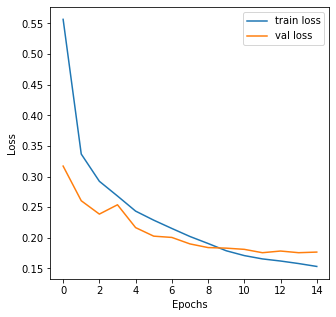

In [24]:
#loss curves
plt.figure(figsize=(5,5))
plt.plot(training_log.train_loss.to_list(), label='train loss')
plt.plot(training_log.val_loss.to_list(), label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('preresloss')
plt.show()

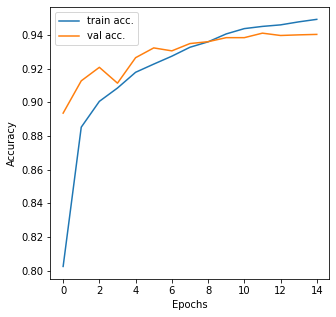

In [49]:
# accuracy
plt.figure(figsize=(5,5))
plt.plot(training_log.train_acc.to_list(), label='train acc.')
plt.plot(training_log.val_acc.to_list(), label='val acc.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('preresacc')
plt.show()

In [37]:
def get_predictions(model, iterator):

    model.eval()

    #images = []
    labels = []
    probs = []

    with torch.no_grad():

        for image, label in tqdm(iterator):

            image = image.to(device)

            label_pred = model(image)

            label_prob = F.softmax(label_pred, dim = -1)

            #images.append(image.cpu())
            labels.append(label.cpu())
            probs.append(label_prob.cpu())

    #images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    pred_labels = torch.argmax(probs, 1)

    return labels, pred_labels

In [38]:
labels, pred_labels = get_predictions(model, test_iterator)

100%|██████████| 63/63 [00:53<00:00,  1.17it/s]


In [39]:
# torch.save(labels,'labels.pt')
# torch.save(pred_labels,'pred_labels.pt')

In [40]:
conf_mat= confusion_matrix(labels,pred_labels)

<AxesSubplot:>

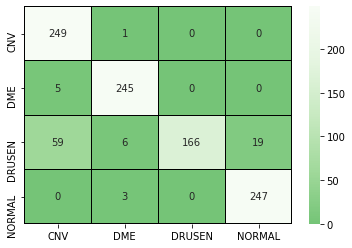

In [41]:
sns.heatmap(conf_mat,annot=True,fmt="0000.0f",
            xticklabels=['CNV','DME','DRUSEN','NORMAL'],
            yticklabels=['CNV','DME','DRUSEN','NORMAL'],
            linecolor='black',
            linewidths=0.1,
            cmap='Greens_r',
            center=0
           )

In [42]:
#Evaluation metrics calculations function

#TP, FP, FN, TN extraction function
def conf_metrics(conf_matrix, label:int):

    TP = conf_mat[label,label]
    FP = conf_mat[:,label].sum() - TP
    FN = conf_mat[label,:].sum() - TP
    TN = conf_mat.sum() - (TP+FP+FN)
    
    return TP, FP, FN, TN

In [43]:
# accuracy calculation function
def accuracy(conf_matrix):
    
    acc =  conf_matrix.diagonal().sum() / conf_matrix.sum()
    
    return round(acc * 100,2)

In [44]:
# sensitivity calculation function
def sensitivity(TP, FN):
    
    sens = TP/(TP + FN)
    
    return round(sens * 100 ,2)

In [45]:
# specificity calculation function
def specificity(TN, FP):
    
    spec = TN/(TN + FP)
    
    return round(spec * 100 ,2)

In [46]:
#performance evaluation

# CNV class
TP, FP, FN, TN = conf_metrics(conf_mat, label= 0)
CNV_sens = sensitivity(TP,FN)
CNV_spec = specificity(TN,FP)

print(f'CNV class sensitivity: {CNV_sens}%')
print(f'CNV class specificity: {CNV_spec}%\n')


# DME class
TP, FP, FN, TN = conf_metrics(conf_mat, label= 1)
DME_sens = sensitivity(TP,FN)
DME_spec = specificity(TN,FP)

print(f'DME class sensitivity: {DME_sens}%')
print(f'DME class specificity: {DME_spec}%\n')

# DRUSEN class
TP, FP, FN, TN = conf_metrics(conf_mat, label= 2)
DRUSEN_sens = sensitivity(TP,FN)
DRUSEN_spec = specificity(TN,FP)

print(f'DRUSEN class sensitivity: {DRUSEN_sens}%')
print(f'DRUSEN class specificity: {DRUSEN_spec}%\n')

# NORMAL class
TP, FP, FN, TN = conf_metrics(conf_mat, label= 3)
NORMAL_sens = sensitivity(TP,FN)
NORMAL_spec = specificity(TN,FP)

print(f'NORMAL class sensitivity: {NORMAL_sens}%')
print(f'NORMAL class specificity: {NORMAL_spec}%\n')

CNV class sensitivity: 99.6%
CNV class specificity: 91.47%

DME class sensitivity: 98.0%
DME class specificity: 98.67%

DRUSEN class sensitivity: 66.4%
DRUSEN class specificity: 100.0%

NORMAL class sensitivity: 98.8%
NORMAL class specificity: 97.47%



In [47]:
#overall performance evaluation 

overall_acc = accuracy(conf_mat)
print(f'Overall accuracy {overall_acc:0.2f}%\n ')

overall_sens = np.mean([CNV_sens,DME_sens,DRUSEN_sens,NORMAL_sens])
print(f'Overall sensitivity {overall_sens:.2f}%\n ')

overall_spec = np.mean([CNV_spec,DME_spec,DRUSEN_spec,NORMAL_spec])
print(f'Overall specificity {overall_spec:.2f}%\n ')

Overall accuracy 90.70%
 
Overall sensitivity 90.70%
 
Overall specificity 96.90%
 
